In [1]:
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, MultiHeadAttention, LayerNormalization, Layer, Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img
from nltk.translate.bleu_score import corpus_bleu
from wordcloud import WordCloud
import tensorflow as tf
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from glob import glob
from matplotlib import pyplot as plt
from string import punctuation
from tqdm import tqdm
import os
import pickle
from transformers import ViTImageProcessor, TFViTModel
from tqdm import tqdm

# Introduction
Image captioning is the process of generating text descriptions for images. In this notebook, I develop a model to generate captions for images using transformers.

# Process Captions
To process the captions, I make all of the text lowercase and remove characters that are not letters or whitespace (i.e. numbers, punctuation, other symbols). I also add START and END tokens. I then tokenize the sequences.

In [2]:
df_captions = pd.read_csv('results.csv', sep='|')
df_captions.columns = [col.strip() for col in df_captions.columns]
df_captions.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


I check this data for NaN values.

In [3]:
df_captions.loc[df_captions['comment'].isna() | df_captions['comment_number'].isna() | df_captions['image_name'].isna()]

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


This was parsed incorrectly. Fortunately it is just one error and can be fixed manually.

In [4]:
df_captions.iloc[19999]['comment'] = df_captions.iloc[19999]['comment_number'].split(maxsplit=1)[1]

In [5]:
def remove_punct(str):
    output = ''
    for char in str:
        if char not in punctuation:
            output += char
        else:
            output += ' '
    return output

word_tokenize(remove_punct('light-colored. '))

['light', 'colored']

The text is processed by removing punctuation, non-aphabetic characters and some short words, including articles. Stopword removal harmed model performance substantially. A START and END token are added to the beginning and end of each sequence, so the model can be primed to generate sequences and learn to end them early.

In [6]:
df_captions['comment'] = df_captions['comment'].apply(remove_punct)
df_captions['comment'] = df_captions['comment'].apply(lambda x: 'START ' + ''.join([char for char in x if char.isalpha() or char == ' ']).strip().lower() + ' END')
df_captions['comment'] = df_captions['comment'].apply(lambda x: word_tokenize(x))
df_captions['comment'] = df_captions['comment'].apply(lambda x: [word for word in x if word not in ['a', 'an', 'the'] and len(word) > 1])

df_captions.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,"[START, two, young, guys, with, shaggy, hair, ..."
1,1000092795.jpg,1,"[START, two, young, white, males, are, outside..."
2,1000092795.jpg,2,"[START, two, men, in, green, shirts, are, stan..."
3,1000092795.jpg,3,"[START, man, in, blue, shirt, standing, in, ga..."
4,1000092795.jpg,4,"[START, two, friends, enjoy, time, spent, toge..."


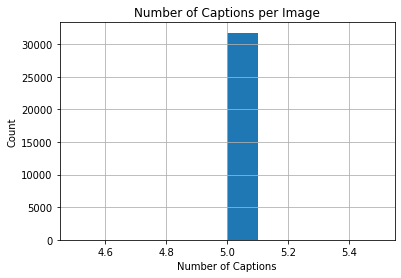

In [7]:
df_captions.groupby('image_name').count()['comment'].hist()
plt.title('Number of Captions per Image')
plt.xlabel('Number of Captions')
plt.ylabel('Count')
plt.show()

As shown above, each image has five captions

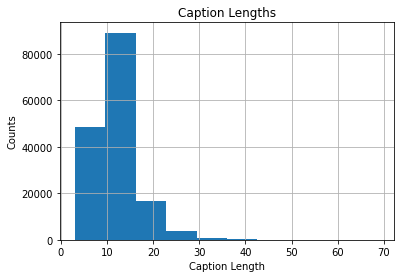

In [8]:
caption_lengths = df_captions['comment'].apply(lambda x: len(x))
caption_lengths.hist()

plt.title('Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Counts')

plt.show()

In [9]:
df_captions['length'] = df_captions['comment'].apply(lambda x: len(x))
df_captions['long'] = df_captions['length'] > 40

In [10]:
# df_captions = df_captions.loc[df_captions['long']==False]

In [11]:
long_captions = df_captions.loc[df_captions['long']==True]['image_name'].values

# df_captions = df_captions.loc[~df_captions['image_name'].isin(long_captions)]

# Splitting Data

Next, I separate the image file names into train, validation test sets.

In [12]:

img_ids = df_captions['image_name'].unique()
train_size = 0.9
val_size = 0.1
test_idx = int(len(img_ids) * train_size)
val_idx = int(test_idx * (1-val_size))
train_ids = img_ids[:val_idx]
val_ids = img_ids[val_idx:test_idx]
test_ids = img_ids[test_idx:]

In [13]:
len(train_ids)

25743

# Vectorizing Captions
The data must be fed into the model as numbers, not text. To do so, mappings are created from tokens to integers. A list of tokens is then "vectorized" as a list of integers. Each integer can further be imagined as shorthand for a vocab_size dimensional one-hot encoded vector, where the integer is the component set to one. This one-hot vector is a ground-truth probability distribution against which predictions will be compared using cross-entropy.

In [14]:
def flatten_corpus(corpus):
    '''
    Takes in a list of lists of tokens and returns a single list of all of the tokens. Effectively the same operation as Numpy's flatten.
    '''
    flat_corpus = []
    for line in corpus:
        flat_corpus.extend(line)
    return flat_corpus

def make_tok2idx(corpus):
    '''
    Take in a list of lists of tokens and returns a dictionary mapping each token to an index
    '''
    flat_corpus = flatten_corpus(corpus)
    unique_toks = list(set(flat_corpus))
    tok2idx = {'PAD':0, 'UNK':1}
    tok_idx = 2
    for tok in unique_toks:
        tok2idx[tok] = tok_idx
        tok_idx += 1
    return tok2idx

df_train = df_captions.loc[df_captions['image_name'].isin(train_ids), 'comment']
tok2idx = make_tok2idx(df_train)
idx2tok = dict((value, key) for key, value in tok2idx.items())    

In [15]:
def vectorize_seq(sequence):
    '''
    Takes in a list of tokens and returns a list of indices.
    '''
    vector = []
    for tok in sequence:
        next_idx = tok2idx.get(tok)
        if next_idx is not None:
            vector.append(next_idx)
        else:
            vector.append(tok2idx['UNK'])
    return vector

def get_max_len(sequences):
    '''
    Takes in a list of lists of tokens and returns the length of the longest sequence.
    '''
    sequences = [vectorize_seq(seq) for seq in sequences]
    max_len = np.max([len(vector) for vector in sequences])
    return max_len

max_len = get_max_len(df_train)

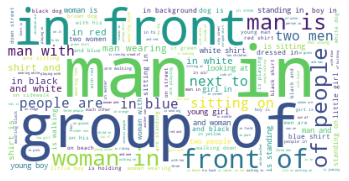

In [16]:
wc = WordCloud(repeat=False, background_color='white', stopwords=['START', 'END'])
wc.generate(' '.join(flatten_corpus(df_train)))

plt.axis('off')
plt.imshow(wc)
plt.show()

# Image Feature Extraction TODO



In [17]:
target_size = (224, 224) # original vit size
fe_size = 768

vit = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86,389,248
Trainable params: 86,389,248
Non-trainable params: 0
_________________________________________________________________


To save on memory, I will not load the images now. Rather, I will write a generator that will load samples as the models train.

In [18]:
img_names = os.listdir('flickr30k_images')
ends = [name.split('.')[1] for name in img_names]
set(ends)

{'jpg'}

In [19]:
len(os.listdir('flickr30k_images'))//6

5297

I extract features from images and store them on the disk. While running a single image through the ViT is not too slow, the ViT is slow enough that extracting features while the model is training slows down training substantially, in addition to repeating the same operations over and over again.

In [20]:
def extract_features(img_dir, batch_size):
    feature_dir = 'vit_features/'
    img_names = os.listdir(img_dir)
    preprocess = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")    

    
    print('writing features')
    for img_name in tqdm(img_names):
        id = img_name.split('.')[0]
        # Load Image
        img = load_img(img_dir + '/' + img_name, target_size=target_size)
        # Preprocess
        img = preprocess(img, return_tensors='tf')['pixel_values'][0]
        img = np.expand_dims(img, axis=0) 
        # Get features       
        img_features = vit.predict(img, verbose=0)
        
        
        pickle.dump(img_features, open(f'{feature_dir}{id}.pkl', 'wb'))
    
if 'vit_features' not in os.listdir():
    extract_features('flickr30k_images', batch_size=6)

# Model Training Input Processing
The text inputs and targets are processed like sequence to sequence inputs and outputs, i.e. the output is the input shifted by one.

The model is trained from a generator due to memory constraints.

In [21]:
def load_img_descriptions(img_ids, max_len=max_len):
    '''
    Processes the caption for an image ID. Returns the inputs and targets for the ID.
    '''
    descriptions = df_captions.loc[df_captions['image_name'].isin(img_ids)]['comment'].values
    descriptions = [vectorize_seq(description) for description in descriptions]
    inputs = np.zeros((len(descriptions), max_len))
    targets = np.zeros((len(descriptions), max_len))
    
    for i, description in enumerate(descriptions):
        for j, tok in enumerate(description):
            inputs[i][j] = tok
            if j > 0: # targets = inputs shifted by 1
                targets[i][j-1] = tok
    return inputs, targets

In [23]:
ex_id = train_ids[0].split('.')[0]

In [24]:
def load_img_features(img_id):
    '''
    Loads image features from a pickle file given corresponding image filename
    '''
    feature_id = img_id.split('.')[0]
    with open('vit_features/' + feature_id +'.pkl', 'rb') as f:
        pooled_outputs = pickle.load(f)['pooler_output']
    return pooled_outputs


def data_gen(generator_ids, img_dir, batch_size):
    '''
    Yields a batch of data: text inputs, text targets, and image features.
    '''
    preprocess = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

    while True:
        num_samples = len(generator_ids)
        start_idx = 0
        num_caption_per_img = 5
        feature_dir = 'vit_features/'
        for i in range(0, num_samples, batch_size):
            
            # Get a batch of ids
            end_idx = start_idx + batch_size
            if end_idx >= num_samples:
                batch = generator_ids[start_idx:]
            else:
                batch = generator_ids[start_idx:end_idx]
            start_idx += batch_size
            
            # Load image features
            feature_locs = [img_dir+'/'+id.split('.')[0]+'.pkl' for id in batch]
            
            img_features = [load_img_features(id) for id in batch]
            img_features = tf.concat([tf.repeat(feats, num_caption_per_img, axis=0) for feats in img_features], axis=0)
            
            # Get text sequences
            text_inputs, text_targets = load_img_descriptions(batch)
            

            yield (text_inputs, img_features), text_targets

# Positional Embeddings and Transformer Decoder
This section contains layers needed for the transformer and a layer to combine text and image features. The first is a positional embedding feature. Transformers have many benefits over RNNs, but they do not by themselves encode position. The positional embedding here is simple. The model learns embeddings both encode positional information and semantic information. The positional embeddings are an element-wise sum of those weights.

The transformer is the transformer decoder from [Attention is All You Need](https://arxiv.org/abs/1706.03762). While it does not affect the architecture of the transformer decoder, it should be noted that in the paper the transformer was used for machine translation in a sequence to sequence architecture, thus the decoder performed self-attention and attention between source and target language sequences. Here, the decoder only performs self-attention.

Finally, there is a custom addition layer.  Here, the image features are (batch_size, 2048), but transformer outputs are (batch_size, max_len, embed_dim). I project the image layers down to embed_dim with a dense layer, then pass those projections to the custom addition layer. This addition layer repeats the image feature projections and reshapes them to (batch_size, max_len, embed_dim), i.e. each batch has max_len image feature projections. The image features and transformer outputs can then be added together.

This custom addittion layer is simply an extrapolation from the process in [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137). In [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137), addition is described as the best way to combine image and text features. However in that paper, they use an RNN where I use the transformer decoder (in addition to performing a slightly diifferent training task, discussed below). Thus in that application addition is trivial - the image features are of some fixed size, say (1, feature_size), so if the RNN's hidden vectors are made to be the same size, the final RNN hidden statee can be added to the image features.

In [25]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.tok_embedding = Embedding(vocab_size, embed_dim)
        self.pos_embedding = Embedding(seq_len, embed_dim)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
    def call(self, x):
        tok_embeds = self.tok_embedding(x)
        
        positions = tf.range(0, tf.shape(x)[-1])
        pos_embeds = self.pos_embedding(positions)
        return tf.add(pos_embeds, tok_embeds)
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.math.not_equal(inputs, 0)
        return mask
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'seq_len': self.seq_len,
                'vocab_size': self.vocab_size,
                'embed_dim': self.embed_dim
            }
        )
        return config

In [26]:
class TransformerDecoder(Layer):
    def __init__(self, num_heads, embed_dim, dense_units, dropout=0.0, **kwargs):
        '''
        Transformer decoder using Vaswani attention.
        Parameters: num_heads, number of heads for multi-head attention
                    embed_dim, embedding dimension of input sequences
                    dense_units, number of units in non-linear dense layer
        '''
        super().__init__(**kwargs)
        self.self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.dense = Dense(dense_units, activation='relu')
        self.linear = Dense(embed_dim)
        self.self_attention_layernorm = LayerNormalization()
        self.attention_layernorm = LayerNormalization()
        self.dense_layernorm = LayerNormalization()
        self.num_heads = num_heads
        self.key_dim = embed_dim 
        self.dense_units = dense_units
        self.supports_masking = True
        self.dropout_rate = dropout
        
    def call(self, query, values, mask=None, track_weights=False):
        '''
        Forward pass for transformer decoder using Vaswani attention
        '''
        # Make causal masks
        causal_mask = self.make_causal_mask(query)
        
        # Make padding mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask) # Masks both "future" targets the model shouldn't see and padding tokens
        
        # Self-attention
        self_attention_output = self.self_attention(query, query, attention_mask=causal_mask)
        normed_self_attention_output = self.self_attention_layernorm(values + self_attention_output)
        
        # Attention over encoder inputs
        attention_output = self.attention(normed_self_attention_output, values, attention_mask=padding_mask)
        normed_attention_outputs = self.attention_layernorm(attention_output + normed_self_attention_output)
        
        # Projections wiith dense layers
        x = self.dense(normed_attention_outputs)
        x = self.linear(x)
        decoder_outputs = self.dense_layernorm(x + normed_attention_outputs)
        
        return decoder_outputs
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'num_heads': self.num_heads,
                'key_dem': self.key_dim,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate
            }
        )
        return config
        
    def make_causal_mask(self, inputs): 
        '''
        Makes a mask to prevent attention layers from seeing future characters during training
        '''
        inputs_shape = tf.shape(inputs) 
        batch_size, seq_len = inputs_shape[0], inputs_shape[1]
        a = tf.range(seq_len)[:, tf.newaxis]
        b = tf.range(seq_len)

        causal_mask = tf.cast(a >= b, 'int32') # creates a (seq_len, seq_len) LT matrix with ones on and below diag

        # Stack batch_size causal masks on top of each other
        causal_mask = tf.reshape(causal_mask, (1, seq_len, seq_len))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype='int32')], axis=0)
        causal_mask = tf.tile(causal_mask, mult)
        return causal_mask

In [27]:
class AddImageToText(Layer):
    '''
    Adds the feature from an image to the output of a transformer called on a text sequence. The transformer returns (batch_size, seq_len, embed_dim) while the image features are only (batch_size, embed_dim), so the image 
    features are repeated seq_len times for each sample in the batch
    '''
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.supports_masking = True
        
    def call(self, img, text_sequence):
        img = tf.repeat(img, self.seq_len, axis=0)
        img = tf.reshape(img, shape=(-1, self.seq_len, self.embed_dim))
        sum = tf.add(img, text_sequence)
        return sum
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'embed_dim': self.embed_dim,
                'seq_len': self.seq_len
            }
        )
        return config

# Build Model
The model architecture is very similar to an encoder-decoder architecture, but with separate "encoders" for text and image data. The encoder for the image data is just the pretrained vit model - this is called in the data generator. The encoder for the text data is a transformer. Since transformers have no concept of sequence order, positional embeddings are used. The encoded data is combined and fed into the decoder, which is a simple classification model. The outputs are sequences of distributions calculated using a softmax function. In this sense, the model is roughly a sequence to sequence model.

This model is similar to the injection model described in the paper [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137) with two notable exceptions. First, the paper uses an RNN as the text encoder, while I use a transformer. Second, my model is trained an a pseudo-sequence-to-sequence fashion in the sense that inputs are a sequence and outputs are the sequence shifted by one. This is a more natural use of a transformer than the training method described in the paper, in my opinion.

In [28]:
num_heads = 4
transformer_dense_units = 2048
transformer_dropout_rate = 0.0
dropout_rate = 0.3
embed_dim = 256
vocab_size = len(tok2idx)

In [29]:

# Text encoder
text_inputs = Input(shape=(None,), name='text_inputs')
text_inputs = Dropout(dropout_rate)(text_inputs)

text_embedding_layer = PositionalEmbedding(seq_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim, name='text_embeds')
text_embeds = text_embedding_layer(text_inputs)

text_embeds = Dropout(dropout_rate)(text_embeds)

text_transformer = TransformerDecoder(num_heads=num_heads, embed_dim=embed_dim, dense_units=transformer_dense_units, dropout=transformer_dropout_rate)
text_encoded = text_transformer(text_embeds, text_embeds)


# Image_encoder
image_inputs = Input(shape=(fe_size,), name='image_inputs')
image_inputs = Dropout(dropout_rate)(image_inputs)
image_encoded = Dense(embed_dim, activation='relu')(image_inputs)

# Combine encoded data
encoded = AddImageToText(seq_len=max_len, embed_dim=embed_dim)(image_encoded, text_encoded)

# "Decoder"
x = Dropout(dropout_rate)(encoded)
x = Dense(2048, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

model = Model([text_inputs, image_inputs], outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 text_embeds (PositionalEmbeddi  (None, None, 256)   4173056     ['input_1[0][0]']                
 ng)                                                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dropout_38 (Dropout)           (None, None, 256)    0           ['text_embeds[1][0]']        

In [41]:
batch_size = 6 # This corresponds to 30 sets of inputs a batch       
train_gen = data_gen(train_ids, 'flickr30k_images', batch_size=batch_size)
val_gen = data_gen(val_ids, 'flickr30k_images', batch_size=batch_size)

lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, min_delta=0.01, patience=5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0.01, patience=10, restore_best_weights=True)


model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy')
history = model.fit(train_gen, 
          steps_per_epoch=len(train_ids)//batch_size, 
          validation_data=val_gen, 
          validation_steps=(len(val_ids))//batch_size, 
          epochs=200, 
          callbacks=[lr, es])

Epoch 1/200
4290/4290 [==============================] - 727s 169ms/step - loss: 0.5616 - val_loss: 0.6684 - lr: 1.0000e-05
Epoch 2/200
4290/4290 [==============================] - 798s 186ms/step - loss: 0.5557 - val_loss: 0.6652 - lr: 1.0000e-05
Epoch 3/200
4290/4290 [==============================] - 463s 108ms/step - loss: 0.5506 - val_loss: 0.6622 - lr: 1.0000e-05
Epoch 4/200
4290/4290 [==============================] - 548s 128ms/step - loss: 0.5464 - val_loss: 0.6594 - lr: 1.0000e-05
Epoch 5/200
4290/4290 [==============================] - 867s 202ms/step - loss: 0.5424 - val_loss: 0.6572 - lr: 1.0000e-05
Epoch 6/200
4290/4290 [==============================] - 549s 128ms/step - loss: 0.5388 - val_loss: 0.6549 - lr: 1.0000e-05
Epoch 7/200
4290/4290 [==============================] - 662s 154ms/step - loss: 0.5353 - val_loss: 0.6530 - lr: 1.0000e-05
Epoch 8/200
4290/4290 [==============================] - 387s 90ms/step - loss: 0.5321 - val_loss: 0.6513 - lr: 1.0000e-05
Epoch 9/2

KeyboardInterrupt: 

# Inference
Inference is similar to a sequence to sequence model. First the "START" token is fed into the model along with an image. The next token is selected using the argmax of the final model output. The next token is added to the input sequence, which is then fed into the model. This process repeats until either the model predicts an END token or it produces a sentence of some maximum length.

Before evaluating performance using BLEU score, I print out some example images. The title printed on each image is the predicted caption. The ground truth captions are printted below each image.

In [42]:
def vec_to_tok(vector):
    return [idx2tok[tok] for tok in vector]

preprocess = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k") 

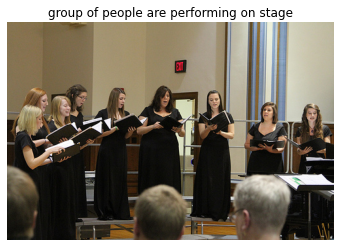

GROUND TRUTH LABELS
women dressed in long black dresses holding booklet up sheet music in front of them singing in choir you can see back of older gentlemen heads who appear to be audience
there is group of nine young women wearing long black dresses holding folders standing on metal bleachers and singing in front of group of people
nine females are standing in semi circle with black binders in their hands
group of women sing together while wearing matching black dresses
female choir all dressed in black giving performance


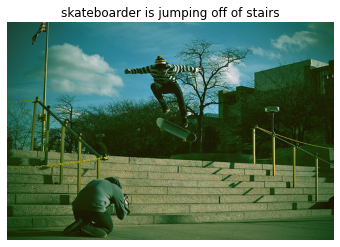

GROUND TRUTH LABELS
man squatting in foreground of photograph while taking photograph of his own of man doing skateboarding kick flip in midair above short flight of stairs outdoors
man wearing striped top and jeans does skateboard trick on some steps while man who is hunched over photographs him
one young man flying on his skateboard above flight of stone stairs while another young man videotapes him
young man is performing jump on skateboard while another young man photographs his stunt
young man doing trick on skateboard down stairs while being photographed


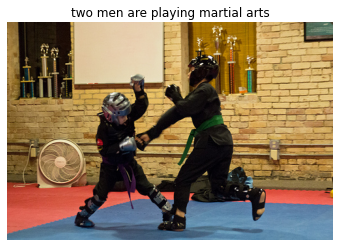

GROUND TRUTH LABELS
two young children in black clothing and padding perform martial arts match where they compete against other
two boys in karate gear one green belt other purple belt spar inside of brick building
two children dressed in black compete against one another in martial art
two people dressed in black are competing in martial arts match
two kids are doing karate or some type of martial arts


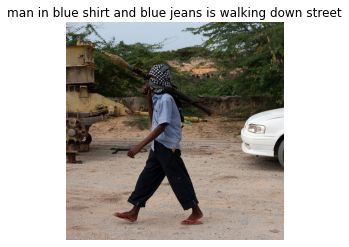

GROUND TRUTH LABELS
young person wears red sandals black pants and blue shirt his head and face covered with checked scarf and carrying rocket launcher
masked man carries rocket propelled grenade over his right shoulder while walking down street
man who head and face is covered is walking with rather large weapon on his shoulder
man who has his face covered with turban is carrying weapon
middle eastern militant man wears flip flops


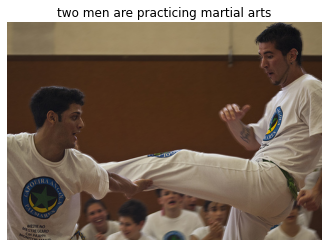

GROUND TRUTH LABELS
two men do karate one strikes sideways with his arm while other kicks straight out in front of him
two martial artists fight in front of group of people
two men are performing what looks like martial arts
man on left dodges his attacker strike
two martial artists sparring as onlooker watch


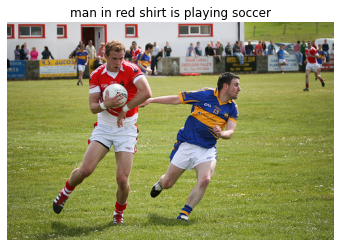

GROUND TRUTH LABELS
number reaches out as he turns directions in effort to deflect anticipated path of football during game
two athletes are on field one in red on left grabs ball away from man next to him
two men one in red jersey holding ball and other in blue jersey run on grassy field
soccer player wearing blue is trying to block opposing team from catching soccer ball
young men are playing rugby and are on opposite teams


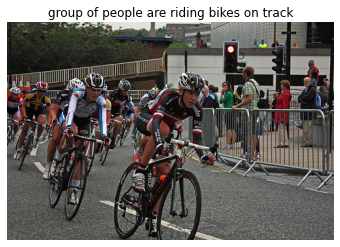

GROUND TRUTH LABELS
group of bicycle racers rounds turn on asphalt street as spectators watch from behind temporary barriers
focused man wearing black leads pack in this bike race
several bicycle riders racing across paved road
cyclists are racing around curve
view of front runner at event


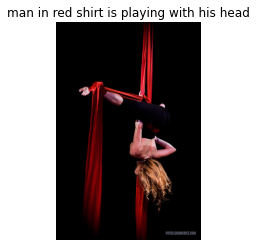

GROUND TRUTH LABELS
female acrobat with long blond curly hair dangling upside down while suspending herself from long red ribbons of fabric
woman is hanging upside down suspended from two red ropes
performance artist suspended upside down from red ribbons
woman is hanging upside down by piece of red fabric
woman acrobatically dangles from hanging curtains


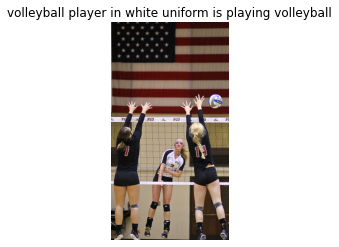

GROUND TRUTH LABELS
two members of volleyball team jump up in attempt to block ball that was just hit by opposing team player
three women playing volleyball and two are jumping to attempt to block shot
three girls playing volleyball are jumping into air to hit ball
one woman spikes volleyball while two women try to block it
three girls playing volleyball with flag in background


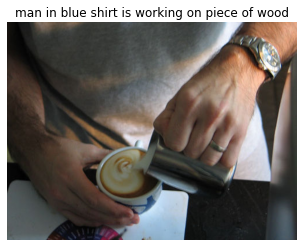

GROUND TRUTH LABELS
married man wearing watch that appears to be about clock is pouring cream into coffee type beverage in blue and white cup
man with hairy arms and watch pours creamer into cup of coffee making color ripples along surface
man wearing wedding band is pouring white liquid into cup of brown liquid
man with silver watch is pouring cream into coffee
man is adding steamed milk to coffee beverage


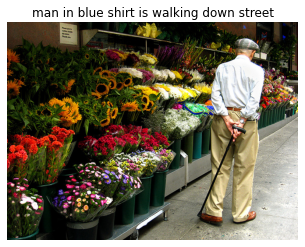

GROUND TRUTH LABELS
older man with white shirt golf cap and cane walks away from outdoor flower shop
elderly man holds can behind his back as he strolls by beautiful flower market
older man with cane walks along row of flowers
elderly man with cane examines flowers at florist
old man is walking past by flower shop


In [65]:
def img_to_features(img_path):
    caption_string = 'START'
    image = load_img(img_path, target_size=target_size)
    image = preprocess(image)['pixel_values'][0]
    image = np.expand_dims(image, axis=0) 
    # Get features
    image_features = vit.predict(image, verbose=0)['pooler_output']
    
    return image_features

def get_caption(img_path, from_features=False):
    '''
    Returns a caption given a path to an image. The "from_features" flag will use features stored on the disk. Intended only to be used to calculate the BLEU score.
    '''
    caption_string = 'START'
    # Get image features
    if from_features:
        img_id = img_path.split('/')[1].split('.')[0]
        image_features = load_img_features(img_id)   
    else:       
        image_features = img_to_features(img_path)
    
    for i in range(max_len):
        caption_idxs = vectorize_seq(caption_string.split(' '))
        vectorized_sentence = np.zeros((1, max_len))
        for i, idx in enumerate(caption_idxs):
            vectorized_sentence[0][i] = idx
        
        # Get next token index
        prediction = model([vectorized_sentence, image_features])
        next_tok_idx = np.argmax(prediction[0, i, :])
        
        # Update string
        next_tok = idx2tok[next_tok_idx]
        caption_string += ' ' + next_tok
        
        # Break if END predicted
        if next_tok == 'END':
            break
        
    if caption_string.endswith('END'):
        return ' '.join(caption_string.split(' ')[1:-1])
    else:
        return ' '.join(caption_string.split(' ')[1:])
    

def plot_img(img_loc):
    '''
    Plots and image with its predicted caption
    '''
    img = load_img(img_loc)
    pred_caption = get_caption(img_loc, from_features=False)
    plt.axis('off')
    plt.title(pred_caption)
    plt.imshow(img)
    plt.show()
    

test_idxs = range(0, len(test_ids), len(test_ids)//10)
for idx in test_idxs:
    #idx = 3000
    img_id = test_ids[idx]
    img_dir = 'flickr30k_images'
    img_loc = img_dir + '/' + img_id

    plot_img(img_loc)
    print('GROUND TRUTH LABELS')
    true_captions = [' '.join(caption_list[1:-1]) for caption_list in  df_captions[df_captions['image_name'] == test_ids[idx]]['comment'].values]
    for caption in true_captions:
        print(caption)


These captions vary in quality, but most of them are at least useful with notable exceptions being the dancer with the red cloth and the person making coffee. Something interesting to note is that, judging just from this handful of examples, the model seems to have learned a grammatical structure. Generally speaking, each caption begins with a type of person or people (man, volleyball player, etc.), sometimes modified by an adjective, followed by an item of clothing ('blue shirt'), and ending with an activity ('practicing martial arts').

Of course, we can only say so much about the model by subjectively evaluating its performance. In the next section, the model is evaluated quantitatively.

# Model Evaluation
The model is evaluated using BLEU score. BLEU-N score quantifies the degree of overlap between N-grams in a hypothesis captions and a corresponding set of reference sequences. That is, BLEU-1 looks at the overlap in unigrams, BLEU-2 the overlap in bigrams, etc. The score ranges between 0 and 1, with higher scores being better. BLEU correlates with human judgment (in machine translating, its original domain of application), but quantifying human judgment about text quality is often imperfect.

Two points are useful to remember when evaluating the score. First, as N increases, it is reasonable to expect the score to decrease. A model is more likely to include a single word in a reference text than a sequence of two, for example. Second, as the number of reference texts increases, it is reasonable to expect the BLEU score to increase. We are more likely to find an N-gram if we can look for it in two reference sequences than if we can only look in one.

In [55]:
pred_caption_dict = {}
for id in tqdm(test_ids):
    img_loc = 'flickr30k_images/'+id
    pred_caption_dict[id] = get_caption(img_loc, from_features=True)

100%|██████████| 3179/3179 [09:27<00:00,  5.60it/s] 


In [56]:
references = []
hypotheses = []
for id in test_ids:
    true_captions = [caption_list for caption_list in  df_captions[df_captions['image_name'] == id]['comment'].values]
    references.append(true_captions)
    hypotheses.append(word_tokenize(pred_caption_dict[id]))

In [57]:
bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, hypotheses, weights=(1/3, 1/3, 1/3, 0))
bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print(f'BLEU-1: {bleu_1}')
print(f'BLEU-2: {bleu_2}')
print(f'BLEU-3: {bleu_3}')
print(f'BLEU-4: {bleu_4}')

BLEU-1: 0.47439352048671063
BLEU-2: 0.28035005940492946
BLEU-3: 0.16198235887317386
BLEU-4: 0.09228396220910703


# Conclusion
This model is outperformed by the RNN model. The transformer architecture encodes fewer assumptions about the structure of the data, in addition to having much more parameters, than an RNN model. I suspect this makes the model more difficult to train. Additionally, recall from above that the captions are short. One problem with RNNs is that they compute a hidden vector meant to capture a sequence sequentially. For long sequences, the RNN may not "remember" information from early in the sequence. Transformers, specifically attention, remedy this problem, but that benefit will be less pronounced for short sequences.